<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Redes neuronales recurrentes con Keras


<u>Consideraciones generales</u>:

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Contexto y carga de librerias

En esta PEC vamos a utilizar redes recurrentes para trabajar con datos temporales.

Para esta PEC se ha seleccionado dos series con datos recurrentes de la FRED (Federal Reserve Economic Data). Por un lado tenemos la variable fecha, por otro el Índice de Sentimiento del Consumidor de la Universidad de Michigan. Este índice es una medida de la confianza que tienen los consumidores en la economía de los Estados Unidos. Se basa en encuestas en las que se pregunta a los consumidores sobre sus percepciones y actitudes actuales hacia las finanzas personales, las condiciones económicas generales y las intenciones de compra de bienes duraderos. Los valores altos indican un mayor nivel de confianza del consumidor, lo que generalmente se considera positivo para el gasto del consumidor y, por ende, para la economía. La tercera variable va a ser Producción Industrial. Esta serie mide la producción real de todas las instalaciones ubicadas en el sector manufacturero de los EE. UU. según el Sistema de Clasificación de la Industria de América del Norte (NAICS). Es un indicador importante de la salud económica, ya que refleja el nivel de actividad de las fábricas, minas y servicios públicos. Un aumento en la producción industrial sugiere un crecimiento económico, mientras que una disminución puede indicar una contracción económica.

Nuestra tarea final es la predicción de la tendencia a futuro teniendo la información de ambas gráficas.

Los objetivos de la práctica son:

*   Interpretanción de los datos disponibles, limpieza y normalizado.
*   Creación de un modelo de predicción basado en una GRU, RNN y LSTM. Propondremos diferentes arquitecturas y deberemos escoger la que mejor _performance_ nos ofrezca.
*   Una vez tengamos entrenado los modelos. Debemos evaluar los modelos por nuevos datos, identificar la necesidad de re-entrenamiento y evaluar nuestro _performance_ del modelo en un entorno de producción para ser capaz de identificar si está funcionando correctamente.

A continuación, os dejamos inicializadas la serie de librerías que necesitarás instalar para utilizar en esta PEC2.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [ ]:
sns.set_style('whitegrid')
np.random.seed(42)

**Importante para guardar vuestros modelos ya entrenados y evitar volver a reentrenarlos cada vez que os desaparezca la sesión online de vuestro servicio Cloud (Google Colab, Kaggle, etc.).**

Podéis utilizar la siguiente ruta:

In [ ]:
results_path = Path('results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

# 1. Carga de Datos / Análisis / Preprocesado / Visualización

## 1.1. Carga, limpieza y transformación de datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> En este ejercicio debes cargar dos series importantes: el Índice de Sentimiento del Consumidor y la Producción Industrial. Una vez cargados los datos con el código que se proporciona:</p>
  <ul>
     <li>Transforma las columnas <code>ip</code> y <code>sentiment</code> realizando una transformación logarítmica diferencial de un periódo anual de 12 meses. Si existen NaN values, elimínalos.</li>
    <li>Aplica una escala min-max a los datos transformados.</li>
    <li>Visualiza ambas series en un gráfico. Es decir, las series de tiempo originales y transformadas para comparar cómo las transformaciones afectan la distribución y tendencia de los datos.</li>
  </ul>
</div>

In [ ]:
# Carga de datos
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2023-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1980-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


,sentiment,ip
DATE,,
1980-01-01,67.0,45.9070
1980-02-01,66.9,46.9873
1980-03-01,56.5,47.5088
1980-04-01,52.7,46.1199
1980-05-01,51.7,44.7920


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Transformación de datos a escala log.
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
                                'sentiment': df.sentiment.diff(12)})
                  .dropna())

In [ ]:
# Normalización min max
df_transformed = df_transformed.apply(minmax_scale)

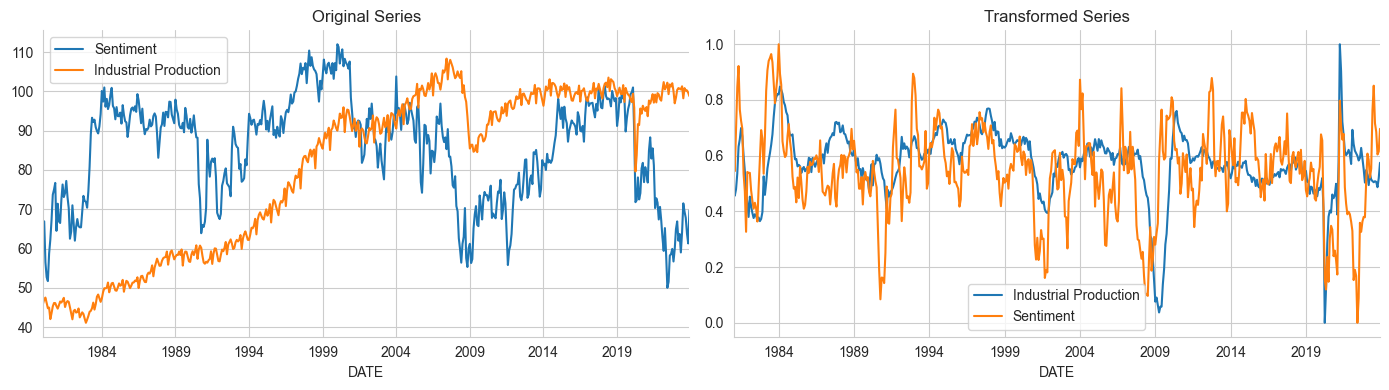

In [ ]:
# Visualización de datos
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
columns={'ip': 'Industrial Production', 'sentiment': 'Sentiment'}
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Transformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)

## 1.2. Preparación de Datos para Modelo Multivariable

Una vez que ya hemos preprocesado los datos, vamos a prepararlos para darle el formato específico que necesita una red recurrente.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Prepara los datos para un modelo de red neuronal recurrente multivariante:</p>
  <ul>
    <li>Define y aplica una función <code>create_multivariate_rnn_data</code> que transforme el conjunto de datos <code>df</code> creado en el ejercicio anterior en un formato adecuado para entrenar un modelo recurrente. La función debe tomar como entrada el conjunto de datos y el tamaño de la ventana (<code>window_size</code>) y devolver una estructura de datos que contenga las secuencias de entrada (<code>X</code>) y las etiquetas objetivo (<code>y</code>).</li>
    <li>Utiliza un <code>window_size</code> de 6 meses para crear tus conjuntos de datos <code>X</code> e <code>y</code>. Verifica las dimensiones de los conjuntos resultantes para asegurarte de que la transformación se haya realizado correctamente.</li>
    <li>Divide los datos transformados en conjuntos de entrenamiento y prueba, utilizando los últimos 24 meses de datos como conjunto de prueba. Asegúrate de que tanto los datos de entrada (<code>X_train</code>, <code>X_test</code>) como las etiquetas (<code>y_train</code>, <code>y_test</code>) estén correctamente particionados.</li>
  </ul>
</div>

In [ ]:
# Redacta tu solución aquí

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Función para crear transformación de datos en base a un tamaño de ventana
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j]
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [ ]:
# Transformación con ventana de 6 meses
window_size = 6
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)
X.shape, y.shape

((510, 6, 2), (510, 2))

In [ ]:
# División Training-Test
test_size = 24
train_size = X.shape[0]-test_size

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, X_test.shape

((486, 6, 2), (24, 6, 2))

# 2. Creación del modelo

En este apartado vamos a definir los diferentes modelos y aprenderemos a definir diferentes tipos de redes recurrentes: GRU, RNN y LSTM. En estas además vamos a ir variando sus diferentes parámetros así como sus funciones de pérdida, sus funciones de activación entre capas y otros hiperparámetros.

In [ ]:
# Reseteamos la sesión de Keras
K.clear_session()

# Creación de df para comparar 'accuracy' entre modelos
df_accuracy = pd.DataFrame(columns=['Modelo', 'Accuracy'])

## 2.1. RNN

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Define un modelo de Red Neuronal Recurrente (RNN) simple utilizando Keras. Sigue los pasos para construir la arquitectura del modelo descrita a continuación:</p>
  <ul>
    <li>Define la arquitectura del modelo utilizando la clase <code>Sequential</code> de Keras. Añade una capa <code>SimpleRNN</code> con los parámetros establecidos, incluyendo una tasa de dropout de 0.1 para regularización y evitar el sobreajuste. Asegúrate de que la capa RNN esté configurada para no devolver secuencias, permitiendo una conexión directa a las capas densas posteriores.</li>
    <li>Establece el número de características de entrada (<code>n_features</code>) y el tamaño de salida (<code>output_size</code>) del modelo, ambos fijados en 2, correspondientes a las dos series temporales que se modelarán.</li>
    <li>Configura los hiperparámetros de la red, incluyendo el número de unidades en la capa RNN (<code>rnn_units=12</code>) y el número de unidades en la capa densa (<code>dense_units=6</code>).</li>
    <li>Incluye una capa densa con la activación 'relu' seguida de una capa de salida con la activación 'linear', adecuada para tareas de regresión como la predicción de series temporales.</li>
    <li>Visualiza un resumen del modelo para revisar su estructura y el número total de parámetros entrenables.</li>
    <li>Compila el modelo utilizando 'RMSProp' como optimizador y 'mae' (error absoluto medio) como función de pérdida. Esta configuración es típicamente efectiva para problemas de regresión donde se busca minimizar la diferencia absoluta entre los valores predichos y los valores reales.</li>
  </ul>
</div>

In [ ]:
# Solución

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
n_features = output_size = 2
rnn_units = 12
dense_units = 6

rnn_model = Sequential([
    SimpleRNN(units=rnn_units,
              dropout=0.1,
              recurrent_dropout=0.1,
              input_shape=(window_size, n_features),
              name='SimpleRNN',
              return_sequences=False),
    Dense(dense_units, activation='relu', name='FC'),
    Dense(output_size, activation='linear', name='Output')
])

rnn_model.summary()
rnn_model.compile(loss='mae', optimizer='RMSProp')

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 12)                180       
                                                                 
 FC (Dense)                  (None, 6)                 78        
                                                                 
 Output (Dense)              (None, 2)                 14        
                                                                 
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


2024-04-15 22:44:02.756070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 22:44:02.756591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Entrena el modelo RNN definido anteriormente y utiliza técnicas de monitoreo durante el entrenamiento para mejorar el rendimiento del modelo:</p>
  <ul>
    <li>Entrena el modelo utilizando el conjunto de entrenamiento (<code>X_train</code>, <code>y_train</code>) y valida usando el conjunto de prueba (<code>X_test</code>, <code>y_test</code>). Ajusta el número de épocas, el tamaño del lote (<code>batch_size=20</code>), y desactiva el barajado de los datos (<code>shuffle=False</code>) para mantener la secuencialidad de los mismos durante el entrenamiento.</li>
    <li>Configura una ruta de archivo donde guardar el mejor modelo entrenado. Usa la estructura de carpetas y el nombre de archivo <code>rnn.h5</code> para este propósito, asegurándote de ajustar el camino según tu entorno de trabajo.</li>
    <li>Implementa un callback de <code>ModelCheckpoint</code> para guardar automáticamente el mejor modelo basándote en el valor de la función de pérdida de validación (<code>val_loss</code>). Asegúrate de configurar este callback para que solo guarde el mejor modelo observado durante el entrenamiento, en términos de pérdida mínima.</li>
    <li>Utiliza el callback de <code>EarlyStopping</code> para detener el entrenamiento si el <code>val_loss</code> no mejora después de un número definido de épocas (<code>patience=10</code>). Este callback ayuda a prevenir el sobreajuste permitiendo que el entrenamiento se detenga de manera anticipada si el modelo no está aprendiendo de manera efectiva. Configura <code>EarlyStopping</code> para que restaure los pesos del mejor modelo obtenido durante el entrenamiento.</li>
    <li>Incluye los callbacks de <code>EarlyStopping</code> y <code>ModelCheckpoint</code> en el método <code>fit</code> para monitorear el entrenamiento y asegurar que solo se guarde el mejor modelo basándote en la pérdida de validación.</li>
  </ul>
</div>

In [ ]:
# Solución

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
rnn_path = (results_path / 'rnn.h5').as_posix()

In [ ]:
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              restore_best_weights=True)
result_rnn = rnn_model.fit(X_train,
                            y_train,
                            epochs=50,
                            batch_size=20,
                            shuffle=False,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpointer],
                            verbose=1)

Epoch 1/50


2024-04-15 22:44:03.003480: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-15 22:44:03.403419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.5199
Epoch 1: val_loss improved from inf to 0.26977, saving model to results/time_series/rnn.h5
25/25 [==============================] - 2s 41ms/step - loss: 0.5199 - val_loss: 0.2698
Epoch 2/50
 1/25 [>.............................] - ETA: 0s - loss: 0.2982

2024-04-15 22:44:04.674631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.2677
Epoch 2: val_loss improved from 0.26977 to 0.15066, saving model to results/time_series/rnn.h5
25/25 [==============================] - 1s 27ms/step - loss: 0.2677 - val_loss: 0.1507
Epoch 3/50
23/25 [==========================>...] - ETA: 0s - loss: 0.1909
Epoch 3: val_loss improved from 0.15066 to 0.12876, saving model to results/time_series/rnn.h5
25/25 [==============================] - 1s 25ms/step - loss: 0.1935 - val_loss: 0.1288
Epoch 4/50
24/25 [===========================>..] - ETA: 0s - loss: 0.1556
Epoch 4: val_loss did not improve from 0.12876
25/25 [==============================] - 1s 25ms/step - loss: 0.1560 - val_loss: 0.1330
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.1341
Epoch 5: val_loss did not improve from 0.12876
25/25 [==============================] - 1s 27ms/step - loss: 0.1341 - val_loss: 0.1307
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.1192


23/25 [==========================>...] - ETA: 0s - loss: 0.0564
Epoch 36: val_loss did not improve from 0.09761
25/25 [==============================] - 1s 26ms/step - loss: 0.0590 - val_loss: 0.0982
Epoch 37/50
25/25 [==============================] - ETA: 0s - loss: 0.0586
Epoch 37: val_loss improved from 0.09761 to 0.09652, saving model to results/time_series/rnn.h5
25/25 [==============================] - 1s 27ms/step - loss: 0.0586 - val_loss: 0.0965
Epoch 38/50
24/25 [===========================>..] - ETA: 0s - loss: 0.0582
Epoch 38: val_loss improved from 0.09652 to 0.09493, saving model to results/time_series/rnn.h5
25/25 [==============================] - 1s 26ms/step - loss: 0.0580 - val_loss: 0.0949
Epoch 39/50
23/25 [==========================>...] - ETA: 0s - loss: 0.0550
Epoch 39: val_loss did not improve from 0.09493
25/25 [==============================] - 1s 25ms/step - loss: 0.0577 - val_loss: 0.0965
Epoch 40/50
24/25 [===========================>..] - ETA: 0s - loss:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Después de entrenar el modelo RNN, visualiza las curvas de entrenamiento vs evualuación.</p>
</div>

In [ ]:
# Solución aquí

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Cargar el modelo optimizado
rnn_model = load_model(rnn_path)


# Save Test Predictions
y_pred = pd.DataFrame(rnn_model.predict(X_test),
                      columns=y_test.columns,
                      index=y_test.index)
y_pred.info()
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)
df_accuracy = df_accuracy.append({'Modelo': 'RNN', 'Accuracy': test_mae}, ignore_index=True)


1/1 [==============================] - 0s 101ms/step
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes
0.0934019303154013


2024-04-15 22:44:37.094463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Realiza una visualización de los resultados del entrenamiento y las predicciones de tu modelo RNN a futuro. Es decir, visualizar la secuencia 'ip' y 'sentiment' de test y compararla con la predicción del modelo.</p>
</div>

In [ ]:
# Código

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
def plot_model_results(history, y_pred, y_train, y_test, test_mae):
    """
    Función para visualizar los resultados del entrenamiento y las predicciones de modelos de series temporales.

    Parameters:
    - history: Objeto de historial devuelto por la función fit() del modelo.
    - y_pred: DataFrame de pandas con las predicciones del modelo.
    - y_train: DataFrame de pandas con los valores de entrenamiento.
    - y_test: DataFrame de pandas con los valores de prueba (verdaderos).
    - test_mae: Float, el valor de MAE en el conjunto de prueba.
    - fig_save_path: String, ruta para guardar la figura generada.
    """
    fig, axes = plt.subplots(ncols=3, figsize=(17, 4))
    pd.DataFrame(history.history).rename(columns={'loss': 'Training', 'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validation Error')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MAE')

    col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment'}

    for i, col in enumerate(y_test.columns, 1):
        y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col_dict[col])
        y_test[col].plot(ax=axes[i], label='out-of-sample')
        y_pred[col].plot(ax=axes[i], label='prediction')
        axes[i].set_xlabel('')

    axes[1].set_ylim(.1, .9)
    axes[1].fill_between(x=y_test.index, y1=0.1, y2=0.9, color='grey', alpha=.5)

    axes[2].set_ylim(.1, .9)
    axes[2].fill_between(x=y_test.index, y1=0.1, y2=0.9, color='grey', alpha=.5)

    plt.legend()
    fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.85)
    plt.show()

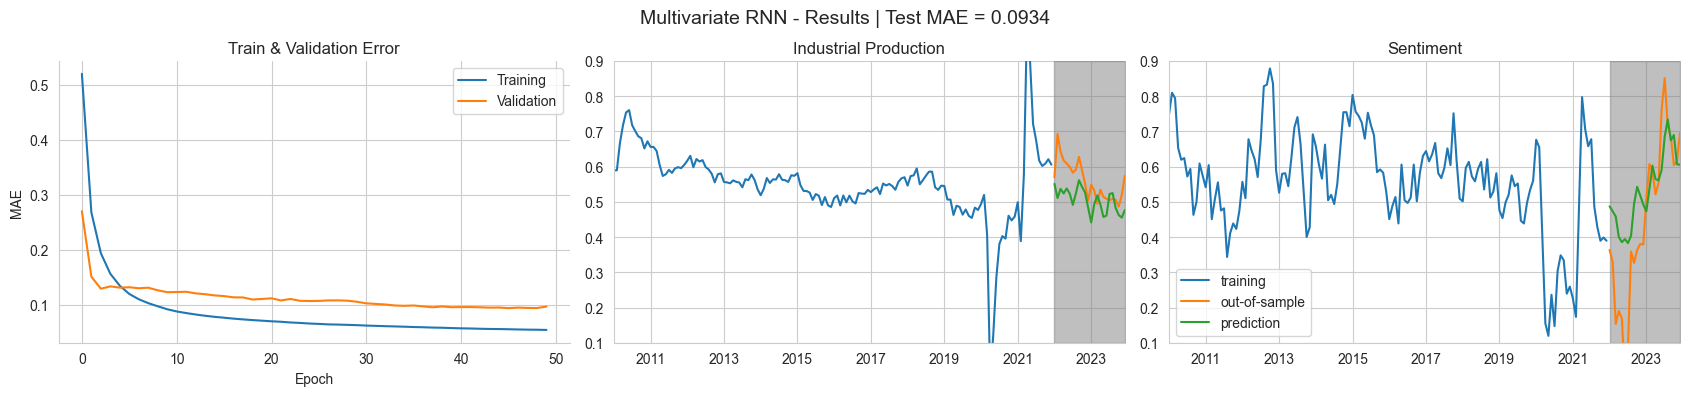

In [ ]:
plot_model_results(result_rnn, y_pred, y_train, y_test, test_mae)

In [ ]:
del result_rnn
del rnn_model

## 2.2. GRU

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Define un modelo utilizando la red GRU en Keras. Sigue los pasos:</p>
  <ul>
    <li>Define el modelo utilizando la clase <code>Sequential</code>. Incorpora una capa <code>GRU</code> con el número de unidades especificado, aplicando un dropout de 0.1 tanto en las entradas como en las conexiones recurrentes para regularizar el modelo. Asegúrate de que la capa GRU no devuelva secuencias, lo cual es adecuado para conectar directamente a capas densas posteriores.</li>
    <li>Configura las variables <code>n_features</code> y <code>output_size</code> para establecer el número de características de entrada y el tamaño de salida del modelo, respectivamente, ambos con un valor de 2.</li>
    <li>Establece los hiperparámetros del modelo: número de unidades en la capa GRU (<code>gru_units=16</code>) y número de unidades en la capa densa (<code>dense_units=8</code>).</li>
    <li>Agrega una capa densa (<code>Dense</code>) con <code>dense_units</code> unidades, similar a la estructura del modelo RNN.</li>
    <li>Finaliza la arquitectura del modelo con una capa de salida (<code>Dense</code>) que tenga un tamaño igual al <code>output_size</code>.</li>
    <li>Muestra un resumen del modelo con el método <code>summary()</code> para verificar la configuración de la arquitectura.</li>
    <li>Compila el modelo utilizando el optimizador 'RMSProp' y la función de pérdida 'mae'.</li>
  </ul>
</div>

In [ ]:
K.clear_session()
# Solución

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
n_features = output_size = 2
gru_units = 12
dense_units = 6

gru_model = Sequential([
    GRU(units=gru_units,
        dropout=0.1,
        recurrent_dropout=0.1,
        input_shape=(window_size, n_features),
        name='GRU',
        return_sequences=False),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output')
])
gru_model.summary()
gru_model.compile(loss='mae', optimizer='RMSProp')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 12)                576       
                                                                 
 FC (Dense)                  (None, 6)                 78        
                                                                 
 Output (Dense)              (None, 2)                 14        
                                                                 
Total params: 668
Trainable params: 668
Non-trainable params: 0
_________________________________________________________________


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Entrena el modelo GRU, visualiza las curvas de entrenamiento vs. evualuación y finalmente visualiza la predicción a futuro tal y como se ha hecho anteriormente.</p>
</div>

In [ ]:
# Solución

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Modelo ****************************
gru_path = (results_path / 'gru.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=gru_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              restore_best_weights=True)
result_gru = gru_model.fit(X_train,
                            y_train,
                            epochs=50,
                            batch_size=20,
                            shuffle=False,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpointer],
                            verbose=1)

Epoch 1/50


2024-04-15 22:44:38.468675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.2980

2024-04-15 22:44:41.170160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.13041, saving model to results/time_series/gru.h5
25/25 [==============================] - 4s 95ms/step - loss: 0.2980 - val_loss: 0.1304
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.0919
Epoch 2: val_loss improved from 0.13041 to 0.11195, saving model to results/time_series/gru.h5
25/25 [==============================] - 2s 78ms/step - loss: 0.0919 - val_loss: 0.1119
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.0854
Epoch 3: val_loss improved from 0.11195 to 0.10276, saving model to results/time_series/gru.h5
25/25 [==============================] - 2s 73ms/step - loss: 0.0854 - val_loss: 0.1028
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.0814
Epoch 4: val_loss improved from 0.10276 to 0.09639, saving model to results/time_series/gru.h5
25/25 [==============================] - 2s 73ms/step - loss: 0.0814 - val_loss: 0.0964
Epoch 5/50
25/25 [============================

1/1 [==============================] - 0s 195ms/step


2024-04-15 22:45:17.060279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes
0.08992552484259457


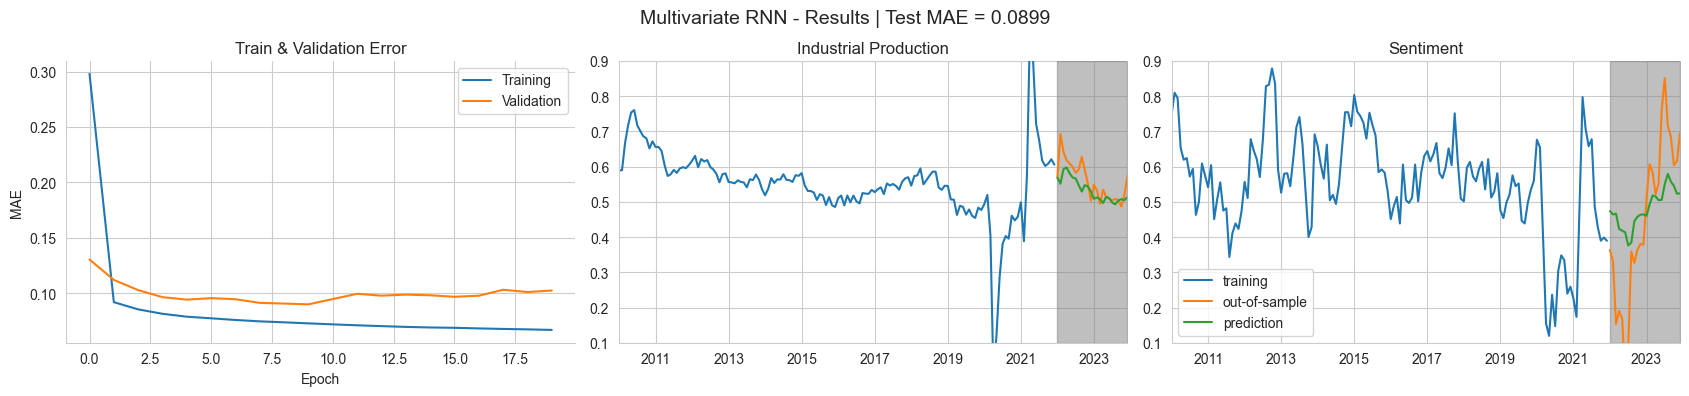

In [ ]:
# Curva de entrenamiento ****************************
# Cargar el modelo optimizado
gru_model = load_model(gru_path)

y_pred = pd.DataFrame(gru_model.predict(X_test),
                      columns=y_test.columns,
                      index=y_test.index)
y_pred.info()
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)
df_accuracy = df_accuracy.append({'Modelo': 'GRU', 'Accuracy': test_mae}, ignore_index=True)

# Visualización ****************************
plot_model_results(result_gru, y_pred, y_train, y_test, test_mae)

In [ ]:
del result_gru
del gru_model

## 2.3. LSTM

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Define un modelo utilizando la capa LSTM en Keras. Esta arquitectura es adecuada para aprender dependencias de largo plazo en series temporales. Sigue los pasos:</p>
  <ul>
    <li>Utiliza la clase <code>Sequential</code> para definir el modelo. Añade una capa <code>LSTM</code> con el número de unidades especificado, aplicando un dropout del 10% tanto en las entradas como en las conexiones recurrentes para ayudar a prevenir el sobreajuste. Asegúrate de que la capa LSTM esté configurada para no devolver secuencias, lo cual facilita la conexión directa con capas densas posteriores.</li>
    <li>Configura las variables <code>n_features</code> y <code>output_size</code> para indicar el número de características de entrada y el tamaño de salida del modelo, respectivamente, ambos fijados en 2 para este ejercicio.</li>
    <li>Establece los hiperparámetros del modelo: número de unidades en la capa LSTM (<code>lstm_units=12</code>) y número de unidades en la capa densa (<code>dense_units=6</code>).</li>
    <li>Integra una capa densa (<code>Dense</code>) con <code>dense_units</code> unidades. Esta capa servirá como capa de conexión antes de la salida del modelo.</li>
    <li>Concluye la arquitectura del modelo con una capa de salida (<code>Dense</code>) que tenga un tamaño igual al <code>output_size</code>.</li>
    <li>Muestra un resumen del modelo con el método <code>summary()</code> para confirmar la configuración de la arquitectura.</li>
    <li>Compila el modelo utilizando 'RMSProp' como optimizador y 'mae'.</li>
  </ul>
</div>

In [ ]:
K.clear_session()
# Solución

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
n_features = output_size = 2
lstm_units = 12
dense_units = 6

lstm_model = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features), name='LSTM',
         return_sequences=False),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output')
])
lstm_model.summary()
lstm_model.compile(loss='mae', optimizer='RMSProp')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 12)                720       
                                                                 
 FC (Dense)                  (None, 6)                 78        
                                                                 
 Output (Dense)              (None, 2)                 14        
                                                                 
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Entrena el modelo LSTM, visualiza las curvas de entrenamiento vs. evualuación y finalmente visualiza la predicción a futuro tal y cómo se ha hecho anteriormente.</p>
</div>

In [ ]:
# Solución

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

Epoch 1/50


2024-04-15 22:45:18.535466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.3470
Epoch 1: val_loss improved from inf to 0.21773, saving model to results/time_series/lstm.h5
25/25 [==============================] - 4s 102ms/step - loss: 0.3470 - val_loss: 0.2177
Epoch 2/50


2024-04-15 22:45:21.439060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.1331
Epoch 2: val_loss improved from 0.21773 to 0.18813, saving model to results/time_series/lstm.h5
25/25 [==============================] - 2s 80ms/step - loss: 0.1331 - val_loss: 0.1881
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.1081
Epoch 3: val_loss improved from 0.18813 to 0.17404, saving model to results/time_series/lstm.h5
25/25 [==============================] - 2s 81ms/step - loss: 0.1081 - val_loss: 0.1740
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.1010
Epoch 4: val_loss improved from 0.17404 to 0.16299, saving model to results/time_series/lstm.h5
25/25 [==============================] - 2s 82ms/step - loss: 0.1010 - val_loss: 0.1630
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.0966
Epoch 5: val_loss improved from 0.16299 to 0.15459, saving model to results/time_series/lstm.h5
25/25 [==============================] - 2s 82ms/step - loss: 0

1/1 [==============================] - 0s 169ms/step
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes
0.10806588591882844


2024-04-15 22:46:34.749931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


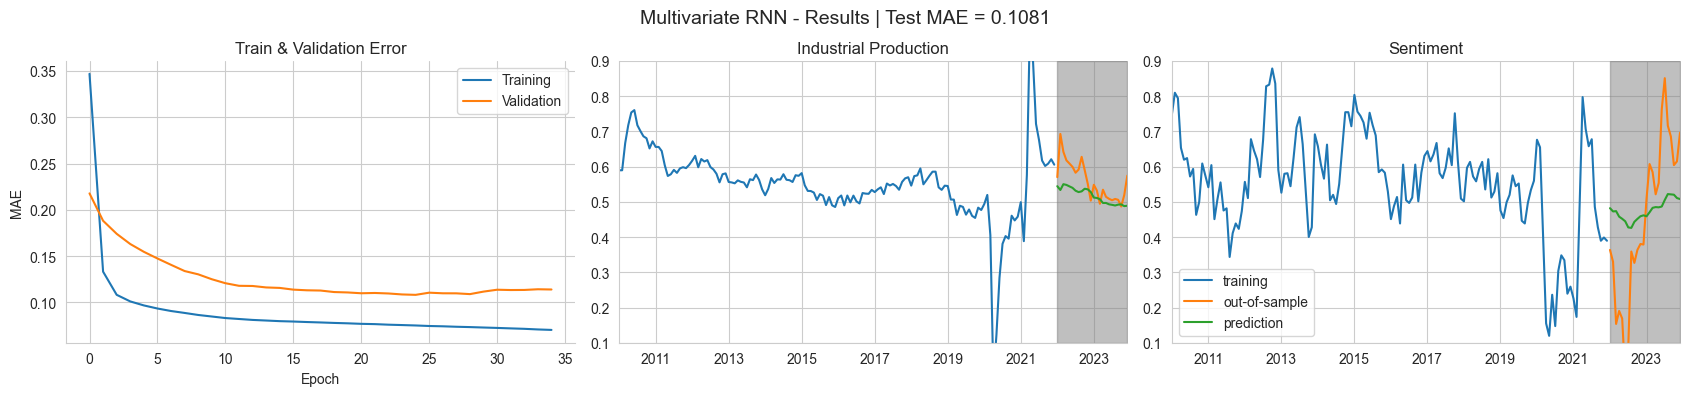

In [ ]:
# Modelo ****************************
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              restore_best_weights=True)
result_lstm = lstm_model.fit(X_train,
                            y_train,
                            epochs=50,
                            batch_size=20,
                            shuffle=False,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpointer],
                            verbose=1)

# Curva de entrenamiento ****************************
y_pred = pd.DataFrame(lstm_model.predict(X_test),
                      columns=y_test.columns,
                      index=y_test.index)
y_pred.info()
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)
df_accuracy = df_accuracy.append({'Modelo': 'LSTM', 'Accuracy': test_mae}, ignore_index=True)

# Visualización ****************************
plot_model_results(result_lstm, y_pred, y_train, y_test, test_mae)

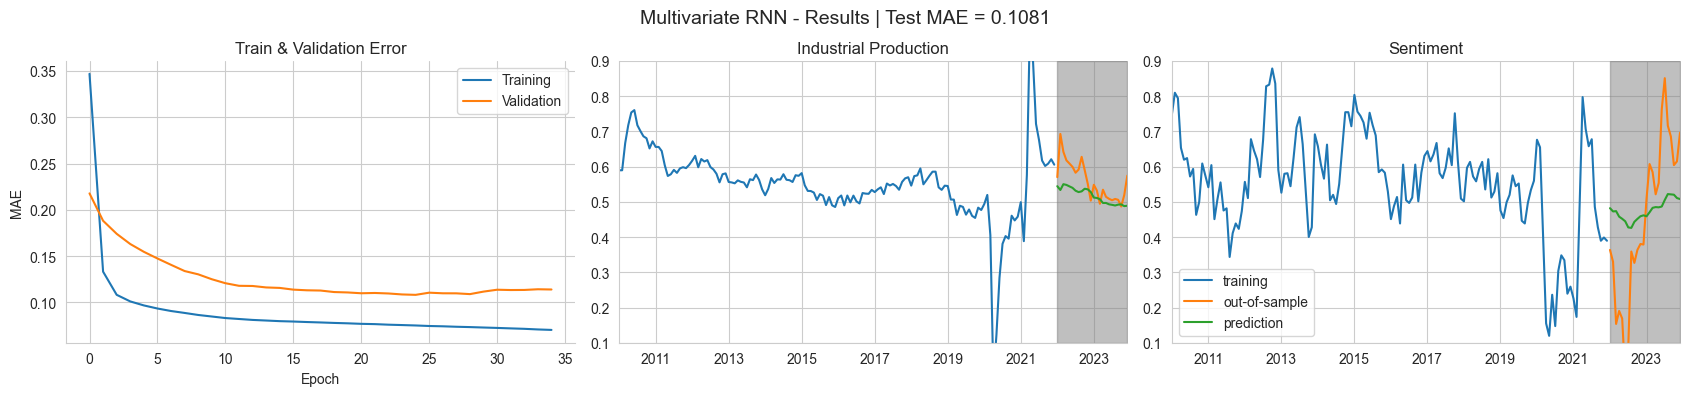

In [ ]:
df_accuracy = df_accuracy.append({'Modelo': 'LSTM', 'Accuracy': test_mae}, ignore_index=True)

# Visualización ****************************
plot_model_results(result_lstm, y_pred, y_train, y_test, test_mae)

In [ ]:
del result_lstm
del lstm_model

## 2.4. LSTM Mejorada

En este apartado vamos a tratar de mejorar la capacidad de la red añadiéndo algunas mejoras que aumentan la capacidad de representación de la red neuronal.

Una de las mejoras va a consistir en utilizar otro tipo de función de activación periódica basada en la fórmula del seno lo que la hace particularmente adecuada para aprender representaciones de datos que son intrínsecamente periódicos o cíclicos.

La función de activación SIREN (SInusoidal REpresentation Networks) es un tipo de función de activación introducida por investigadores para mejorar la capacidad de las redes neuronales, especialmente en tareas que involucran la modelación de fenómenos periódicos o el manejo de derivadas de alto orden, como se ve en tareas de procesamiento de señales, imágenes, y audio. La función SIREN utiliza senos como funciones de activación en lugar de las tradicionales ReLU, sigmoides, o tanh. La fórmula general de una función de activación SIREN es
ϕ
(
x
)
=
sin
⁡
(
w
x
+
b
)
ϕ(x)=sin(wx+b), donde
w
w y
b
b son parámetros que se aprenden durante el entrenamiento de la red.

Esta capa de activación ofrece derivadas suaves y continuas, lo que es beneficioso para modelar relaciones complejas en los datos, incluyendo aquellas donde las derivadas de alto orden son relevantes (como en la modelación física).

Para más información: [https://arxiv.org/abs/2006.09661](https://arxiv.org/abs/2006.09661)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Expande la arquitectura LSTM estándar incorporando una función de activación Sinusoidal (SIREN) para explorar su impacto en el aprendizaje de dependencias temporales complejas. Sigue los pasos para configurar y definir este modelo en Keras:</p>
  <ul>
    <li>Define una función <code>siren_activation</code> que aplique la activación SIREN, utilizando el seno de la entrada multiplicada por un parámetro de frecuencia <code>w0</code>. Este tipo de activación será particularmente útil para modelar patrones periódicos y no linealidades complejas en los datos.</li>
    <li>Configura las variables <code>n_features</code> y <code>output_size</code> para representar el número de características de entrada y el tamaño de salida del modelo, respectivamente, ambos establecidos en 2.</li>
    <li>Establece los hiperparámetros del modelo: número de unidades en la capa LSTM (<code>lstm_units=24</code>), número de unidades en la capa densa (<code>dense_units=12</code>), y tamaño de la ventana de entrada (<code>window_size=24</code>).</li>
    <li>Utiliza la clase <code>Sequential</code> para definir el modelo. Añade una capa <code>LSTM</code> configurada con los parámetros especificados y asegúrate de que no devuelva secuencias para facilitar la conexión directa a la capa densa posterior.</li>
    <li>Incorpora la activación SIREN inmediatamente después de la capa LSTM utilizando la capa <code>Lambda</code>, que permite aplicar funciones personalizadas como parte de la arquitectura del modelo.</li>
    <li>Completa la arquitectura del modelo con una capa densa y una capa de salida, como en modelos LSTM estándar.</li>
    <li>Compila el modelo con 'RMSProp' como optimizador y 'mae'.</li>
    <li>Muestra un resumen del modelo con <code>summary()</code> para confirmar la estructura y configuración de la arquitectura.</li>
    <li>Entrena el modelo como anteriormente.</li>
    <li>Muestra las predicciones visualizando las series temporales.</li>
  </ul>
</div>

In [ ]:
K.clear_session()
# Solución
def siren_activation(x):
    return # Definir la función SENO

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
def siren_activation(x):
    w0 = 1.0
    return tf.sin(w0 * x)

# LSTM
n_features = output_size = 2
lstm_units = 12
dense_units = 6

lstm_model = Sequential([
    LSTM(units=lstm_units,
         dropout=0.1,
         recurrent_dropout=0.1,
         input_shape=(window_size, n_features), name='LSTM',
         return_sequences=False),
    Lambda(siren_activation, name='SIREN_Activation'),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output')
])

# Compilamos
lstm_model.compile(loss='mae', optimizer='RMSProp')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 12)                720       
                                                                 
 SIREN_Activation (Lambda)   (None, 12)                0         
                                                                 
 FC (Dense)                  (None, 6)                 78        
                                                                 
 Output (Dense)              (None, 2)                 14        
                                                                 
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50


2024-04-15 22:46:36.611183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.4161
Epoch 1: val_loss improved from inf to 0.20582, saving model to results/time_series/lstm_siren.h5


2024-04-15 22:46:39.701772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 4s 110ms/step - loss: 0.4161 - val_loss: 0.2058
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.1404
Epoch 2: val_loss improved from 0.20582 to 0.12505, saving model to results/time_series/lstm_siren.h5
25/25 [==============================] - 2s 89ms/step - loss: 0.1404 - val_loss: 0.1250
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.0978
Epoch 3: val_loss improved from 0.12505 to 0.12007, saving model to results/time_series/lstm_siren.h5
25/25 [==============================] - 2s 89ms/step - loss: 0.0978 - val_loss: 0.1201
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.0943
Epoch 4: val_loss improved from 0.12007 to 0.11506, saving model to results/time_series/lstm_siren.h5
25/25 [==============================] - 2s 85ms/step - loss: 0.0943 - val_loss: 0.1151
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.0912
Epoch 5: val_loss improved from 0.11506 t

2024-04-15 22:47:17.675250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


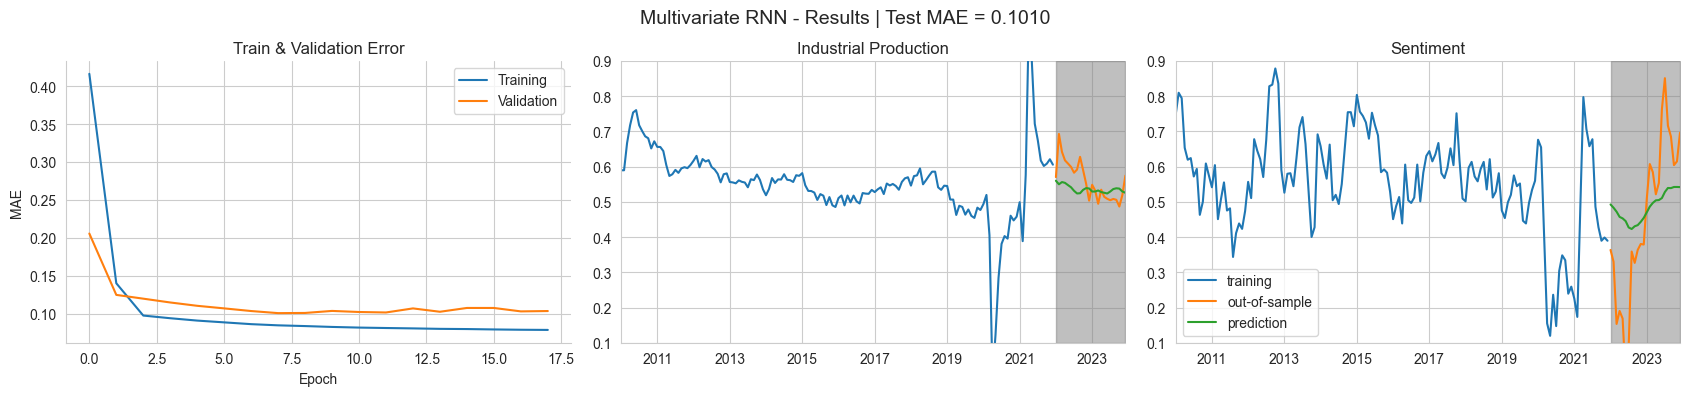

In [ ]:
# Modelo ****************************
lstm_path = (results_path / 'lstm_siren.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              restore_best_weights=True)
result_lstm = lstm_model.fit(X_train,
                            y_train,
                            epochs=50,
                            batch_size=20,
                            shuffle=False,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpointer],
                            verbose=1)

# Curva de entrenamiento ****************************
y_pred = pd.DataFrame(lstm_model.predict(X_test),
                      columns=y_test.columns,
                      index=y_test.index)
y_pred.info()
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)
df_accuracy = df_accuracy.append({'Modelo': 'LSTM_SIREN', 'Accuracy': test_mae}, ignore_index=True)
# Visualización ****************************
plot_model_results(result_lstm, y_pred, y_train, y_test, test_mae)

In [ ]:
del result_lstm
del lstm_model

# 3. Data Evaluation

Hasta ahora hemos aprendido a crear un modelo de red neuronal de tipo recurrente para datos que tienen un factor temporal y debe de ser tomado en cuenta. Sin embargo, en vuestro día a día laboral, necesitaréis no solo crear un buen modelo, sino también ser capaces de justificar por qué habéis diseñado y entrenado un buen modelo. Para ello, se van a proponer una serie de ejercicios que nos van a guiar en esta justificación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Crea una tabla que evalue y compare el rendimiento de tus modelos en los datos de test. ¿Crees que la precisión podría mejorar? Discute si existe la necesidad de reentrenar tu modelo, considerando nuevas estrategias para mejorar su rendimiento.</p>
</div>

In [ ]:
K.clear_session()
# Código aquí

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> La necesidad de reentrenar un modelo puede surgir por varias razones, como cambios en los datos subyacentes, rendimiento insatisfactorio en los datos de prueba o nuevos datos de producción disponibles. Para mejorar el rendimiento del modelo, se podrían adoptar varias estrategias:

Recopilación de más datos: A menudo, más datos pueden ayudar al modelo a aprender mejor, especialmente si los datos adicionales cubren casos que no estaban bien representados en el conjunto de entrenamiento original.

Feature engineering: Mejorar la selección o transformación de las características podría ayudar al modelo a identificar patrones más significativos.

Hiperparametrización: Ajustar los hiperparámetros del modelo, como el número de unidades en las capas, las tasas de dropout, y los tipos de activación, puede tener un impacto significativo en el rendimiento.

Uso de técnicas de regularización: Para combatir el sobreajuste, se podrían explorar técnicas adicionales de regularización más allá del dropout, como la regularización L1/L2 en los pesos de las capas.

Cambio de arquitectura: Experimentar con diferentes arquitecturas de red, como capas más profundas, diferentes tipos de capas recurrentes (GRU, LSTM), o incluso enfoques híbridos.</p>
</div>

In [ ]:
# Mostrar el DataFrame actualizado
print(df_accuracy)

       Modelo  Accuracy
0         RNN  0.093402
1         GRU  0.089926
2        LSTM  0.108066
3        LSTM  0.108066
4  LSTM_SIREN  0.101042


## 3.1. Hiperparametrización

Ahora que has identificado la necesidad de mejorar tu modelo, procede a reentrenarlo utilizando el conjunto de datos de prueba. Además, emplea una herramienta de hiperparametrización como Optuna para ajustar los hiperparámetros del modelo, incluyendo el número de neuronas, tipos de activación de las capas y tasas de dropout.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Realiza una optimización de hiperparámetros utilizando Optuna para el modelo LSTM del ejercicio 2.4. que incorpora una opción de activación personalizada, y entrena el modelo con el conjunto de hiperparámetros óptimos. Finalmente, guarda el modelo entrenado. Sigue estos pasos:</p>
  <ul>
    <li>Define una función <code>create_model</code> que construye el modelo LSTM visto anteriormente pero que hiperparametrizaremos. Dentro de esta función, utiliza Optuna para sugerir valores para los siguientes hiperparámetros: número de unidades en la capa LSTM, número de unidades en la capa densa, tasa de dropout, y el tipo de función de activación (con opciones 'relu' y 'siren').</li>
    <li>Si se elige 'siren' como función de activación, sugiere un valor para el parámetro de frecuencia <code>w0</code> y utiliza la activación SIREN personalizada. De lo contrario, utiliza 'relu'.</li>
    <li>Configura y define el modelo LSTM basado en los hiperparámetros elegidos. Añade una capa LSTM seguida de la activación elegida, una capa densa, y finalmente una capa de salida.</li>
    <li>Define la función <code>de pérdida</code> MAE para la optimización con Optuna que compila y entrena el modelo definido.</li>
    <li>Lanza Optuna para crear un estudio y ejecuta una búsqueda de hiperparámetros limitada a un número definido de pruebas.</li>
    <li>Después de completar la optimización, imprime el número de pruebas completadas y los hiperparámetros del mejor modelo encontrado.</li>
  </ul>
</div>

In [ ]:
# Código
n_features = 2

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong></p>
</div>

In [ ]:
n_features = output_size = 2

def siren_activation(w0):
    def siren(x):
        return tf.sin(w0 * x)
    return siren

def create_model(trial):
    lstm_units = trial.suggest_categorical('lstm_units', [16, 32, 64])
    dense_units = trial.suggest_categorical('dense_units', [8, 16, 32])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    activation_choice = trial.suggest_categorical('activation_choice', ['relu', 'siren'])
    if activation_choice == 'siren':
        w0 = trial.suggest_float('w0', 1.0, 3.0)
        activation_function = siren_activation(w0)
    else:
        activation_function = 'relu'

    model = Sequential()
    model.add(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate,
                   input_shape=(window_size, n_features), return_sequences=False))

    if activation_choice == 'siren':
        model.add(Lambda(activation_function, name='SIREN_Activation'))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size, activation='linear'))
    return model

def objective(trial):
    model = create_model(trial)
    model.compile(optimizer=RMSprop(), loss='mae')

    # Callbacks
    early_stopping = EarlyStopping(patience=3,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=2,
                                  min_lr=0.001,
                                  mode='min',
                                  verbose=0)

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=8,
        shuffle=False,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    val_loss = np.min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

best_params = study.best_trial.params
print('Número de pruebas completadas:', len(study.trials))
print('Mejor prueba:', best_params)

[I 2024-04-15 22:47:18,235] A new study created in memory with name: no-name-4b2ec62f-6fbe-428e-a2ca-696dfd6c22c3


2024-04-15 22:47:19.212517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:47:24.388411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2024-04-15 22:47:49,568] Trial 0 finished with value: 0.07813800871372223 and parameters: {'lstm_units': 32, 'dense_units': 8, 'dropout_rate': 0.45405356832779586, 'activation_choice': 'relu'}. Best is trial 0 with value: 0.07813800871372223.


Número de pruebas completadas: 1
Mejor prueba: {'lstm_units': 32, 'dense_units': 8, 'dropout_rate': 0.45405356832779586, 'activation_choice': 'relu'}


## 3.1.1. Entrenamiento Mejor Modelo de Optuna

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Entrena tu mejor modelo con Optuna:</p>
  <ul>
<li>Crea y entrena un nuevo modelo LSTM utilizando los mejores hiperparámetros identificados. Entrena este modelo en el conjunto de entrenamiento y valida su desempeño utilizando.</li>
    <li>Guarda el modelo entrenado en la ruta especificada y muestra un mensaje confirmando la ubicación del archivo guardado.</li>
      <li>Visualiza las predicciones tal y como se ha hecho anteriormente.</li>
    <li>Añade y compara tu mejor modelo a la tabla anterior para comparar resultados.</li>
        </ul>
</div>

In [ ]:
# Código

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong></p>
</div>

In [ ]:
# Crear y entrenar el modelo con los mejores hiperparámetros
best_model = create_model(study.best_trial)
best_model.compile(optimizer=RMSprop(), loss='mae')
result_best_model = best_model.fit(X_train, y_train,
                                   epochs=50, batch_size=8,
                                   shuffle=False, validation_split=0.2,
                                   verbose=1)

# Guardar el mejor modelo
best_model_path = (results_path / 'best_lstm_model.h5').as_posix()
best_model.save(best_model_path)
print(f"El modelo se ha guardado en {best_model_path}")

Epoch 1/50


2024-04-15 22:47:50.540571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 0.2393

2024-04-15 22:47:55.457393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 6s 95ms/step - loss: 0.2393 - val_loss: 0.0845
Epoch 2/50
49/49 [==============================] - 4s 81ms/step - loss: 0.1150 - val_loss: 0.0772
Epoch 3/50
49/49 [==============================] - 4s 81ms/step - loss: 0.1030 - val_loss: 0.0763
Epoch 4/50
49/49 [==============================] - 4s 82ms/step - loss: 0.0963 - val_loss: 0.0770
Epoch 5/50
49/49 [==============================] - 4s 81ms/step - loss: 0.0909 - val_loss: 0.0879
Epoch 6/50
49/49 [==============================] - 4s 81ms/step - loss: 0.0890 - val_loss: 0.0900
Epoch 7/50
49/49 [==============================] - 4s 82ms/step - loss: 0.0875 - val_loss: 0.0764
Epoch 8/50
49/49 [==============================] - 4s 84ms/step - loss: 0.0863 - val_loss: 0.0838
Epoch 9/50
49/49 [==============================] - 4s 81ms/step - loss: 0.0856 - val_loss: 0.0793
Epoch 10/50
49/49 [==============================] - 4s 84ms/step - loss: 0.0857 - val_loss: 0.0748
Epoch 11/50
49/49 [=

1/1 [==============================] - 0s 192ms/step


2024-04-15 22:51:20.314605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes
0.10570945420678743


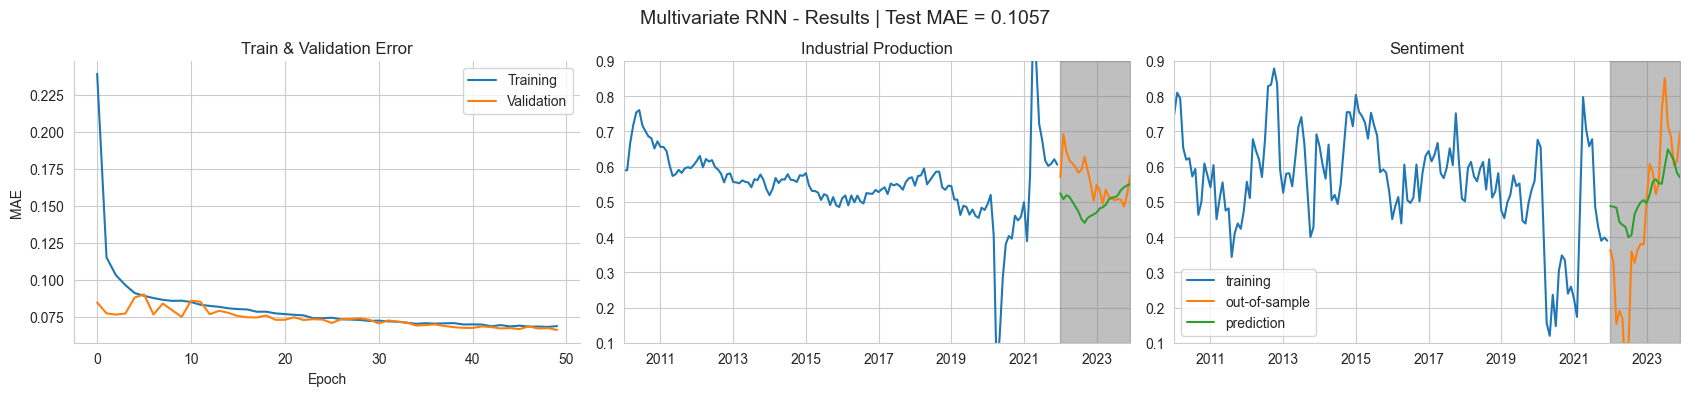

In [ ]:
# Curva de entrenamiento ****************************
y_pred = pd.DataFrame(best_model.predict(X_test),
                      columns=y_test.columns,
                      index=y_test.index)
y_pred.info()
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)
df_accuracy = df_accuracy.append({'Modelo': 'LSTM_BEST', 'Accuracy': test_mae}, ignore_index=True)
# Visualización ****************************
plot_model_results(result_best_model, y_pred, y_train, y_test, test_mae)

In [ ]:
df_accuracy

,Modelo,Accuracy
0,RNN,0.093402
1,GRU,0.089926
2,LSTM,0.108066
3,LSTM,0.108066
4,LSTM_SIREN,0.101042
5,LSTM_BEST,0.105709


## 3.2. Carga de Datos de Producción y Evaluación del Modelo

Supongamos que ahora tienes este anterior modelo corriendo en tu  entorno de producción de tu compañía, pasan 4 meses y deseas evaluar cómo tu modelo optimizado predice estos nuevos datos. Carga estos datos, realiza las transformaciones necesarias y evalúa el modelo.

In [ ]:
# Carga de datos hasta abril de 2024
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2024-04').dropna()
df.columns = ['sentiment', 'ip']
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,45.9070
1980-02-01,66.9,46.9873
1980-03-01,56.5,47.5088
1980-04-01,52.7,46.1199
1980-05-01,51.7,44.7920


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Después de optimizar y entrenar un modelo LSTM utilizando Optuna, realiza los pasos necesarios para evaluar el modelo en un conjunto de datos de prueba y visualizar los resultados. Sigue los mismos pasos que se hicieron al principio de la PEC.:</p>
  <ul>
    <li>Transforma el conjunto de datos original aplicando logaritmo y diferenciación a los datos. Posteriormente, normaliza estos datos transformados usando la escala mínima-máxima.</li>
    <li>Prepara los datos para el entrenamiento utilizando una ventana de tiempo de 6 meses.</li>
    <li>Divide los datos preparados en conjuntos de entrenamiento y test, reservando los últimos 4 meses de datos para test (que serán nuestros datos de producción), y usa el resto para el entrenamiento.</li>
    <li>Carga el modelo LSTM optimizado.</li>
    <li>Genera predicciones para el conjunto de test con el modelo cargado y guarda estas predicciones en un <code>DataFrame</code> de pandas, utilizando las mismas columnas y el índice que el conjunto de prueba para una comparación directa.</li>
    <li>Evalúa el rendimiento del modelo en el conjunto de prueba calculando el Error Absoluto Medio (MAE) entre las predicciones y los valores reales.</li>
    <li>Visualiza los resultados del entrenamiento y la evaluación del modelo, comparando las series temporales de las predicciones del modelo contra los valores reales de entrenamiento y prueba, e incluye el valor de MAE en el título para destacar el rendimiento del modelo.</li>
  </ul>
</div>

In [ ]:
# Solución

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong></p>
</div>

1/1 [==============================] - 0s 180ms/step


2024-04-15 22:51:22.064230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2023-11-01 to 2024-02-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         4 non-null      float32
 1   sentiment  4 non-null      float32
dtypes: float32(2)
memory usage: 64.0 bytes
0.06476442834990298


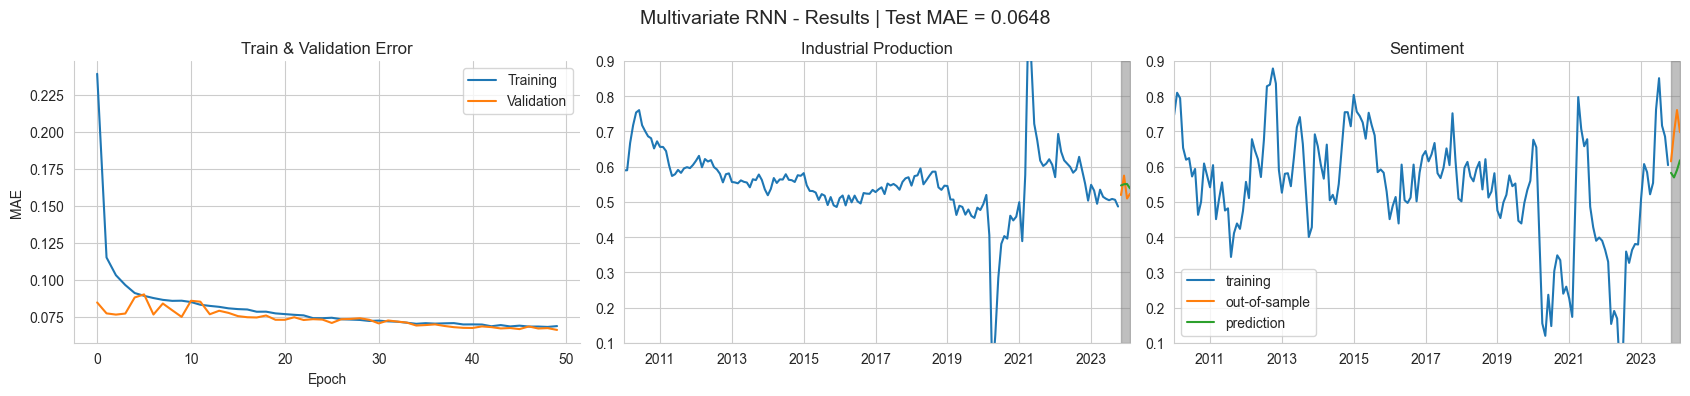

In [ ]:
# Cargar los datos de producción
# Transformación de datos a escala log.
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
                                'sentiment': df.sentiment.diff(12)})
                  .dropna())
# Normalización min max
df_transformed = df_transformed.apply(minmax_scale)

# Transformación con ventana de 24 meses
window_size = 6
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)
X.shape, y.shape

# División Training-Test
test_size = 4
train_size = X.shape[0]-test_size

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, X_test.shape


# Cargar el modelo optimizado
model = load_model(best_model_path, custom_objects={"siren_activation": siren_activation})

# Save Test Predictions
y_pred = pd.DataFrame(model.predict(X_test),
                      columns=y_test.columns,
                      index=y_test.index)
y_pred.info()
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)

# Visualización ****************************
plot_model_results(result_best_model, y_pred, y_train, y_test, test_mae)